In [36]:
import pandas as pd
'''해맷던점: 1. 증권사 api는 파이썬3.8.6 32bit를 설치하고 인터프리터(바꾸는법은 좌측하단)까지 3.8.6 32bit까지 맞춰야 한다.
            2. 관리자 권한으로 파이썬을 실행해야한다.
'''
import win32com.client
import re
import numpy as np
import pandas as pd

# 연결 여부 체크 CpCybos는 CYBOS의 각종 상태를 알수있다.
objCpCybos = win32com.client.Dispatch("CpUtil.CpCybos") 
bConnect = objCpCybos.IsConnect
if (bConnect == 0):
    print("PLUS가 정상적으로 연결되지 않음. ")
    exit()
 
# 국내종목코드 변수(0=구분없음,1=코스피,2=코스닥,3=프리보드(장외),4=krx)
objCpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
codeList = objCpCodeMgr.GetStockListByMarket(1) #거래소 
#GetStockListByMarket():시장구분에 따른 주식종목코드들을 반환



def kospi_etf_filter(codeList,kospi_search_name,kospi_minimum_price):
    
    kospi_etfdata=[]
    kospi_etfindex=[]

    print("거래소 종목코드", len(codeList)) #종목(코드)수
    for i, code in enumerate(codeList): 
        secondCode = objCpCodeMgr.GetStockSectionKind(code) 
        #ETN은 별도 구분이 없다. 종목코드가 Q 로 시작
        #부 구분코드(secondcode) 반환하는 메서드인데 10은 ETF이며 1은 주권(주주가 권리를 가짐)이다.
        names = objCpCodeMgr.CodeToName(code) #종목명불러오기
        stdPrice = objCpCodeMgr.GetStockStdPrice(code) #종목가격 ETN은 가격정보가 없는데 채권형식으로 만기일이 존재하는 형태여서 그런듯
        m=re.search(kospi_search_name, names) 
        #m = re.search('정규표현식', 문자열 소스)
        '''패턴을 컴파일하고 그패턴으로 문자열검색 밑과 같은코드이다.
        p=re.compile('KODEX')
        m=p.search(kospi_search_name)
        '''
        if secondCode==10 and m:
            kospi_etfdata.append([code,stdPrice,names]) #append는 1개의 인자밖에 추가할수 없으므로 리스트로 한곳에 묶는다.
            kospi_etfindex.append(i)

    # print(kospi_etfindex)
    etf_df=pd.DataFrame(kospi_etfdata,index=kospi_etfindex)
    etf_df.columns=['종목코드','주가','종목명'] #-df = df.rename(columns={'NAME': 'kospi_search_name', 'AGE': 'age'})식으로도 가능

    #가격분류 loc 인덱싱
    etf_lastdf=etf_df.loc[etf_df['주가']>kospi_minimum_price] #-loc안에 조건식 *etf_df['주가']>20000] 주의
    return etf_lastdf

kospi_search_name='미국' #검색할거없으면 공란
kospi_minimum_price=20000


objCpSvr7246=win32com.client.Dispatch('Dscbo1.CpSvr7246')

def ETF_NAV(code,days):
    objCpSvr7246.SetInputValue(0,code)
    objCpSvr7246.BlockRequest()
    # data_cnt=objCpSvr7246.GetHeaderValue(0)
    # print(data_cnt) #수신개수 

    '''index=0은 장이 열렸던 가장 최근의 날짜이다.
    date=objCpSvr7246.GetDataValue(0,0) 
    '''
    NAV_list=[]
    for i in range(days-1):  #최근장열린날 기준으로 과거로
        NAV=objCpSvr7246.GetDataValue(6,i)
        NAV_list.append(NAV)

    return NAV_list

if __name__=='__main__':
    etf_lastdf=kospi_etf_filter(codeList,kospi_search_name,kospi_minimum_price)
    etf_codes=etf_lastdf['종목코드']
    etf_lastdf=etf_lastdf.set_index(['종목코드'])
    # print(etf_lastdf)
    '''etf_codedf에 list를 씌우면 '종목코드'만 나옴
    dataframe에 list씌우면 칼럼명이 나온다.
    '''
    navlist=[]
    for code in etf_codes:
        navlist.append(np.mean(ETF_NAV(code,20))) #종목들의 검색된 code의 5일간 NAV_list를 navlist에 추가
    
    etf_lastdf['NAV']=navlist
    # print(etf_lastdf)

거래소 종목코드 1597


In [37]:
etf_lastdf['NAV']

종목코드
A133690     75445.055789
A143850     49358.895263
A181480     89052.850526
A185680     32390.420526
A200030     19302.585789
A203780     20788.033684
A219480     18372.175789
A225040     24501.256316
A245340     16904.252105
A280320     17397.985789
A287180     17851.882105
A314250     21989.058421
A332610    100449.823684
A332620    108759.974211
Name: NAV, dtype: float64

In [38]:
import matplotlib.pylab as plt
import matplotlib
plt.rc('font', family='Malgun Gothic') 

rc 함수로 맑은 고딕체로 글꼴 변경하여 한글 깨짐 막음

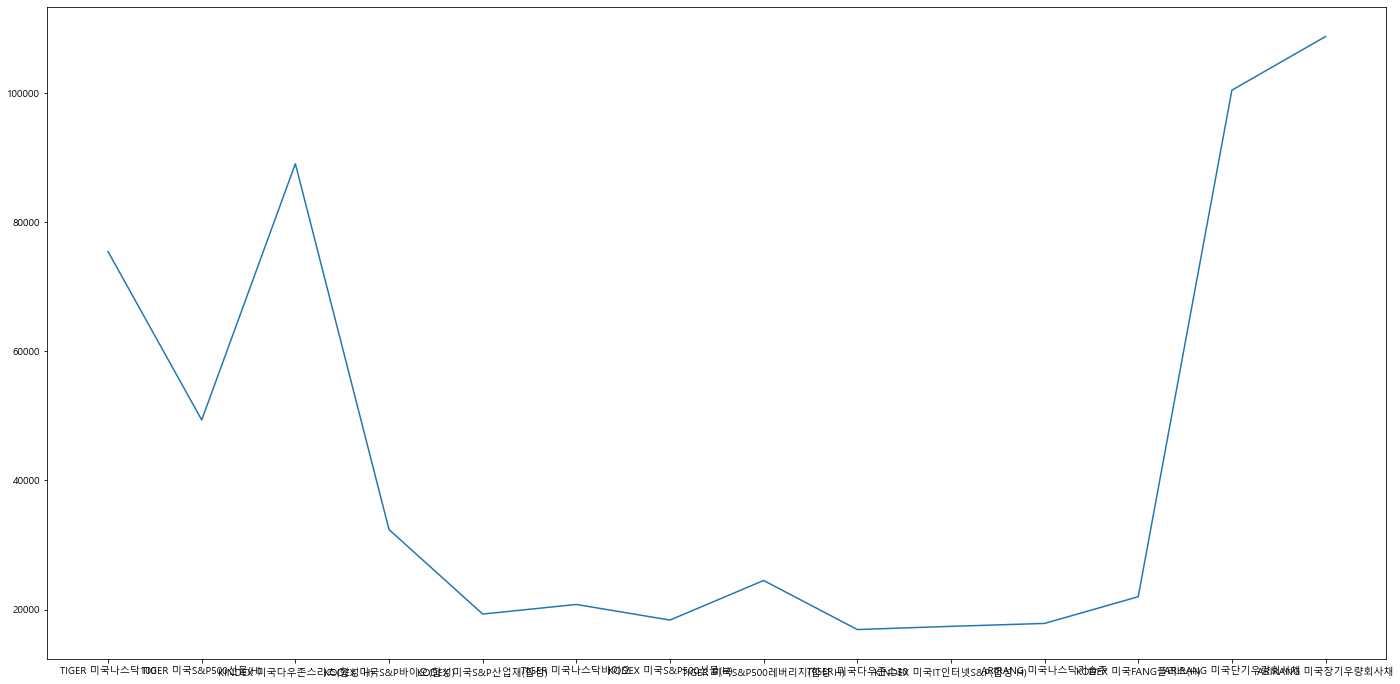

In [43]:
import matplotlib.pylab as plt
plt.figure(figsize=(24,12))
plt.plot(etf_lastdf['종목명'],etf_lastdf['NAV'])
plt.show()